In [1]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import bioframe
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [4]:
# import HiC in .cool or .mcool 
# note: if you are importing HiC in .mcool file, you should specify the resolution
clr = cooler.Cooler('inputs/GSE130275_mESC_WT_combined_2.6B_chr1_3200.cool')
resolution = clr.binsize
print(resolution)

3200


In [5]:
# computing the expected values for each diagonal in cis
view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
expected = cooltools.expected_cis(clr, view_df=view_df, nproc=2, chunksize=1_000_000)
display(expected)

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,59366,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,58806,NaN,NaN,NaN,NaN,3.488489e-04,3.488489e-04
2,chr1,chr1,2,58741,8789487.0,1924.086881,149.631212,0.032755,2.977595e-02,2.977595e-02
3,chr1,chr1,3,58726,4892228.0,1065.963463,83.305997,0.018151,1.797350e-02,1.797350e-02
4,chr1,chr1,4,58723,3391091.0,738.562921,57.747237,0.012577,1.234306e-02,1.234306e-02
...,...,...,...,...,...,...,...,...,...,...
61080,chr1,chr1,61080,0,0.0,0.000000,NaN,NaN,3.737855e-07,3.737855e-07
61081,chr1,chr1,61081,0,0.0,0.000000,NaN,NaN,3.737819e-07,3.737819e-07
61082,chr1,chr1,61082,0,0.0,0.000000,NaN,NaN,3.737782e-07,3.737782e-07
61083,chr1,chr1,61083,0,0.0,0.000000,NaN,NaN,3.737746e-07,3.737746e-07


In [6]:
# import gene annotation in .gft file to extract gene/transcript information
df_gene0 = read_gtf("inputs/mm10.ensGene_chr1.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
109529,chr1,195220051,195222766,-,ENSMUSG00000102236,2715
109531,chr1,195228278,195228398,+,ENSMUSG00000093823,120
109533,chr1,195240910,195241007,-,ENSMUSG00000099208,97
109535,chr1,195259299,195259848,-,ENSMUSG00000104297,549


In [7]:
# select a subset of genes based on size
# Note: the minimum size of the gene is better to be at least 20 times higher than HiC resolution
lmin = 10*resolution
lmax = 20*resolution
df_gene = df_gene0[(df_gene0['length']<lmax)&(df_gene0['length']>lmin)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513
...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962


In [8]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
pol2 = pyBigWig.open("inputs/GSM4173524_DMSO-N20-input_rep1_chr1.bw")
l = len(df_gene)
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'IR_score'] = np.mean(pol2.values(ch,start,end))
df_gene.loc[:,'log2_IR_score'] = np.log2(df_gene['IR_score'])

display(df_gene)

,chrom,start,end,strand,gene_id,length,IR_score,log2_IR_score
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966,0.259446,-1.946495
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622,3.726281,1.897736
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091,4.367942,2.126954
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003,1.216582,0.282834
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513,0.303108,-1.722096
...,...,...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386,0.397804,-1.329869
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043,0.495063,-1.014315
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011,0.389001,-1.362155
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962,1.248526,0.320226


In [9]:
# select gene pairs based on distance and IR scores
# Note1: here we clustered genes based on IR score in three different groups (i.e. Low, Mid, and High)
# Note2: the minimum distance between genes (middle to middle) should be higher than the maximum size of the genes
IR1 = 'High'
IR2 = 'High'
dmin = 20*resolution
dmax = 2_000_000
group = {'Low':1,'Mid':2,'High':3}
df_gene['quartile_IR_score']= pd.qcut(df_gene['log2_IR_score'], 3, labels=False) + 1
paired_sites = bioframe.pair_by_distance(df_gene, min_sep=dmin, 
                                          max_sep=dmax, suffixes=('1', '2'))
paired_sites.loc[:, 'mid1'] = (paired_sites['start1'] + paired_sites['end1'])//2
paired_sites.loc[:, 'mid2'] = (paired_sites['start2'] + paired_sites['end2'])//2
paired_sites['dist'] = abs(paired_sites.mid2-paired_sites.mid1)
sub_paired_sites = paired_sites[(paired_sites['quartile_IR_score1']==group[IR1])&
                             (paired_sites['quartile_IR_score2']==group[IR2])]
sub_paired_sites = sub_paired_sites.reset_index(drop=True)
display(sub_paired_sites)

,chrom1,start1,end1,strand1,gene_id1,length1,IR_score1,log2_IR_score1,quartile_IR_score1,chrom2,...,end2,strand2,gene_id2,length2,IR_score2,log2_IR_score2,quartile_IR_score2,mid1,mid2,dist
0,chr1,36068400,36106446,+,ENSMUSG00000045216,38046,9.424885,3.236475,3,chr1,...,38055579,+,ENSMUSG00000026083,57569,4.550827,2.186129,3,36087423,38026794,1939371
1,chr1,36335730,36369181,-,ENSMUSG00000010453,33451,2.660392,1.411639,3,chr1,...,38055579,+,ENSMUSG00000026083,57569,4.550827,2.186129,3,36352455,38026794,1674339
2,chr1,42851233,42905682,+,ENSMUSG00000060679,54449,1.594439,0.673049,3,chr1,...,44181260,+,ENSMUSG00000026048,33413,1.739467,0.798645,3,42878457,44164553,1286096
3,chr1,57956072,58018956,-,ENSMUSG00000054770,62884,2.692952,1.429189,3,chr1,...,59719044,+,ENSMUSG00000026020,34035,14.230315,3.830896,3,57987514,59702026,1714512
4,chr1,58445267,58481816,+,ENSMUSG00000026036,36549,3.720502,1.895497,3,chr1,...,59719044,+,ENSMUSG00000026020,34035,14.230315,3.830896,3,58463541,59702026,1238485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,chr1,188971095,189007840,-,ENSMUSG00000026608,36745,3.415126,1.771939,3,chr1,...,189688086,-,ENSMUSG00000026605,47480,2.945474,1.558500,3,188989467,189664346,674879
116,chr1,188971095,189007840,-,ENSMUSG00000026608,36745,3.415126,1.771939,3,chr1,...,189922363,-,ENSMUSG00000026603,41871,2.314339,1.210600,3,188989467,189901427,911960
117,chr1,189640606,189688086,-,ENSMUSG00000026605,47480,2.945474,1.558500,3,chr1,...,189922363,-,ENSMUSG00000026603,41871,2.314339,1.210600,3,189664346,189901427,237081
118,chr1,191351975,191397041,-,ENSMUSG00000026626,45066,1.493477,0.578675,3,chr1,...,191575544,-,ENSMUSG00000037474,38179,5.408914,2.435339,3,191374508,191556454,181946


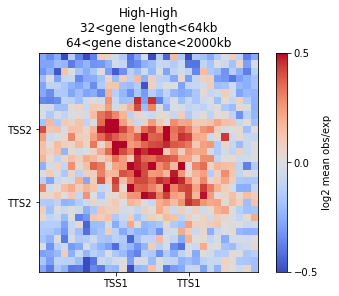

In [10]:
# pileup mtea-gene analysis (PMGA) of inter-gene HiC contact map
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),constrained_layout = True)
def get_row_compressor(old_dimension, new_dimension):
    dim_compressor = np.zeros((new_dimension, old_dimension))
    bin_size = float(old_dimension) / new_dimension
    next_bin_break = bin_size
    which_row = 0
    which_column = 0
    while which_row < dim_compressor.shape[0] and which_column < dim_compressor.shape[1]:
        if round(next_bin_break - which_column, 10) >= 1:
            dim_compressor[which_row, which_column] = 1
            which_column += 1
        elif next_bin_break == which_column:

            which_row += 1
            next_bin_break += bin_size
        else:
            partial_credit = next_bin_break - which_column
            dim_compressor[which_row, which_column] = partial_credit
            which_row += 1
            dim_compressor[which_row, which_column] = 1 - partial_credit
            which_column += 1
            next_bin_break += bin_size
    dim_compressor /= bin_size
    return dim_compressor


def get_column_compressor(old_dimension, new_dimension):
    return get_row_compressor(old_dimension, new_dimension).transpose()

def compress_and_average(array, new_shape):
    # Note: new shape should be smaller in both dimensions than old shape
    return np.mat(get_row_compressor(array.shape[0], new_shape[0])) * \
           np.mat(array) * \
           np.mat(get_column_compressor(array.shape[1], new_shape[1]))

view_df=pd.DataFrame({'chrom':clr.chromnames,
                      'start':0,
                      'end':clr.chromsizes.values,
                      'name':clr.chromnames})
sub_paired_sites['mid1'] = sub_paired_sites['end1']
sub_paired_sites['start1'] = sub_paired_sites['end1']-1
sub_paired_sites['end1'] = sub_paired_sites['end1']+1
sub_paired_sites['mid2'] = sub_paired_sites['end2']
sub_paired_sites['start2'] = sub_paired_sites['end2']-1
sub_paired_sites['end2'] = sub_paired_sites['end2']+1
flank = 2*max(max(sub_paired_sites.length1),max(sub_paired_sites.length2))
stack = cooltools.pileup(clr, sub_paired_sites, view_df=view_df, expected_df=expected, flank=flank)
lm1 = sub_paired_sites.length1[0]//resolution
lm2 = sub_paired_sites.length2[0]//resolution
fm = flank//resolution
m11 = fm-2*lm1
m21 = fm+lm1
m12 = fm-2*lm2
m22 = fm+lm2
mtx0 = stack[m11:m21,m12:m22,0]
stk = np.asarray(compress_and_average(mtx0, (30, 30)))
l = len(sub_paired_sites)
for i in range (1,l):
    lm1 = sub_paired_sites.length1[i]//resolution
    lm2 = sub_paired_sites.length2[i]//resolution
    m11 = fm-2*lm1
    m21 = fm+lm1
    m12 = fm-2*lm2
    m22 = fm+lm2
    mtx0 = stack[m11:m21,m12:m22,i]
    mtx0 = np.asarray(compress_and_average(mtx0, (30, 30)))
    stk = np.dstack((stk,mtx0))
mask1 = np.array(sub_paired_sites.strand1 == '-', dtype=bool)
mask2 = np.array(sub_paired_sites.strand2 == '-', dtype=bool)
stk[:, :, mask1] = stk[::-1, :, mask1]
stk[:, :, mask2] = stk[:, ::-1, mask2]
mtx = np.nanmean(stk, axis=2)
im=ax.imshow(
    np.log2(mtx),
    vmax =  0.5,
    vmin = -0.5,
    cmap='coolwarm',
    interpolation='none')

plt.colorbar(im,label = 'log2 mean obs/exp',ticks=[-0.5, 0, 0.5])
ticks_pixels = [10,20]
ticks_1 = ['TSS1','TTS1']
ticks_2 = ['TSS2','TTS2']
ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_1)
ax.set_yticks(ticks_pixels)
ax.set_yticklabels(ticks_2)
ax.set_title(IR1+'-'+IR2+'\n'
          +str(lmin//1000)+'<gene length<'+str(lmax//1000)+'kb\n'
          +str(dmin//1000)+'<gene distance<'+str(dmax//1000)+'kb')
np.savetxt('outputs/PMGA_intergene_HiC.txt', mtx, fmt='%f')
fig.savefig("outputs/PMGA_intergene_HiC.png")